# Exploring nonparametric methods - Boosted Trees and ANNs

In the last lecture, two new methods were introduced: (Gradient) Boosting on the example of Decision Trees and Artificial Neural Networks (ANNs). These two methods are quite different. Boosting is an ensemble technique that in principal can be applied to any statistical learning method (but is mostly used with Decision Trees) to improve an otherwise unsatisfying result. ANNs, on the other hand, are a completely new, and slightly special statistical learning method that we will explore a bit in this tutorial.

In the following, we will first illustrate how the boosting algorithm works on our already well-known 1D artificial dataset. Then, we will apply it to our 2D artificial dataset and see how Cross-validation helps finding optimal parameters. Then, we will move on to the ANNs. We will fit a simple ANN to our 2D artificial dataset and explore Cross-Validation. 

Finally, both methods are applied to our PSL/precipitation dataset.

In [1]:
library(raster)
library(rworldmap)
library(RColorBrewer)
library(gbm)
library(rpart)
library(nnet)

source('functions.R')
source('../Exercise2/functions.R')
source('../Exercise3/functions.R')

Loading required package: sp

### Welcome to rworldmap ###

For a short introduction type : 	 vignette('rworldmap')

Loaded gbm 2.1.8



## Boosting - Example of Boosted Trees on 1D artificial data

You surely remember our 1D polynomial artificial data, first introduced in the first Exercise. We load it and plot it.

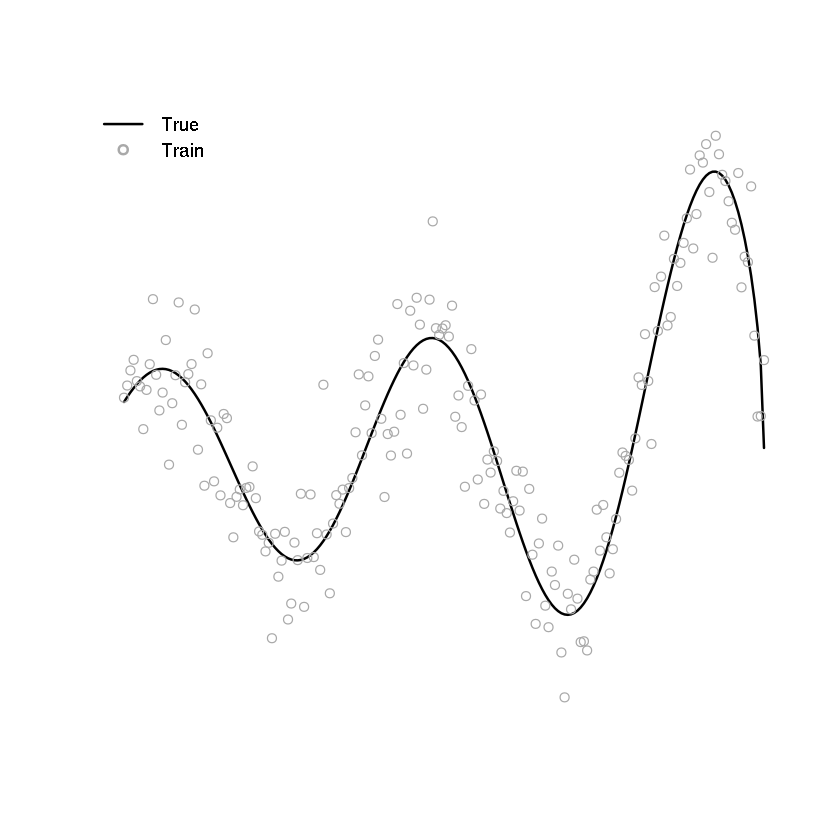

In [2]:
## Load function to create dataset from exercise 1:
source('../Exercise1/functions.R')

## Generate 200 training sample points:
train.data = generate.data.poly(N=200, seed=200, sd.noise=0.15)

## Plot true function and training dataset:
plot(train.data$X, train.data$Y_true, lwd=2, type="l", ylim=c(-0.7,1),axes=F, xaxt='n', ann=FALSE)
points(train.data$X, train.data$Y,col="darkgrey")
legend("topleft",legend=c("True","Train"),col=c("black","darkgrey"),
       lty=c(1,NA),pch=c(NA,1),lwd=2, bty = "n")

Now we set up a Boosted Trees model. Initially, we constrain each tree to only split up into two branches by setting `maxdepth_tree` to `1`. This means that each single Tree is only able to predict one of two different values out of any possible inputs given. Obviously, this is not a very good setting for predicting a polynomial function. But it helps to illustrate how Boosting is able to improve the prediction of weak learners.

We train the first tree and plot its prediction together with the training data. The red lines mark the residuals, i.e. the difference between the model prediction and the data points from the training data.

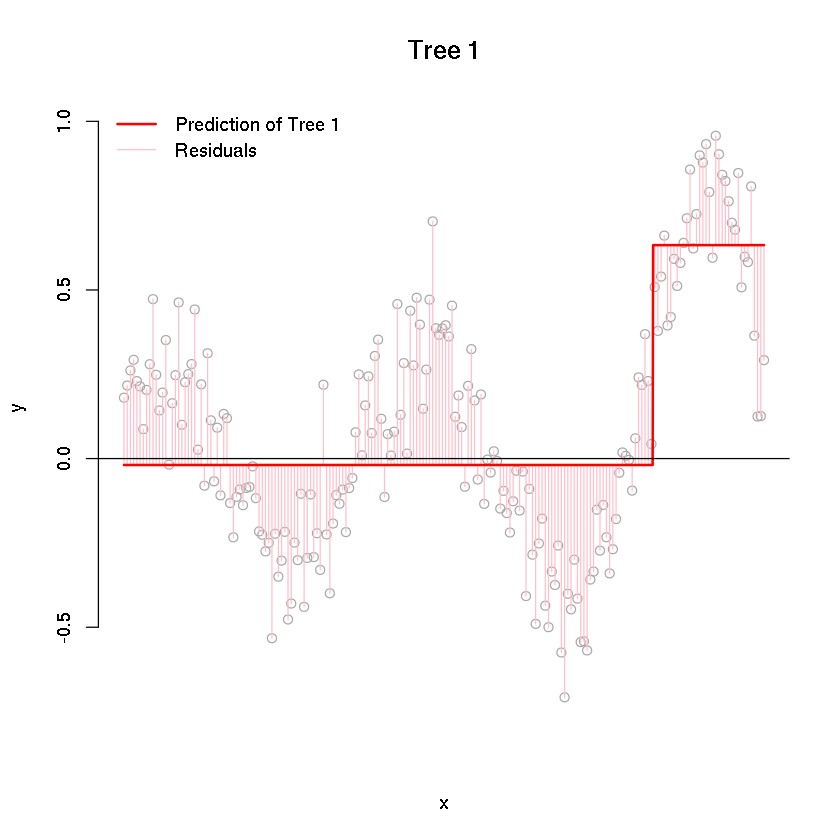

In [3]:
## Set the maximum depth of each single tree:
maxdepth_tree <- 1

## Traing first tree on the training dataset:
train.data.model <- train.data
xy.stump.1 <- rpart(Y~X,data=train.data,control=rpart.control(maxdepth=maxdepth_tree))

## Add residuals and predictions (at training datapoints) to dataframe:
train.data.model["resid_stump_1"] <- resid(xy.stump.1)
train.data.model["pred_stump_1"]  <- predict(xy.stump.1, newdata=data.frame(X=train.data.model$X))
                      
## Make prediction for complete x-axis (not just training datapoints):
x_pred_all <- seq(0,15,0.01)
y_pred_all <- data.frame(predict(xy.stump.1, newdata=data.frame(X=x_pred_all)))
                        
## Plot prediction of first tree and residuals:
plot(train.data.model$X, train.data$Y, ylim=c(-0.7,1),axes=F, xaxt='n', ann=FALSE, col="darkgrey")
segments(x0=train.data.model$X, x1=train.data.model$X,
         y0=train.data.model$pred_stump_1, y1=train.data.model$Y, col="pink")
lines(x_pred_all, y_pred_all[,1], col="red",lwd=2)
legend("topleft", legend=c("Prediction of Tree 1", "Residuals"), lwd=c(2,1), col=c("red","pink"), bty = "n")
title(main="Tree 1",xlab="x",ylab="y")
abline(h=0)
axis(2)

## Get settings for the next plots:
range_resid_1 <- range(train.data.model["pred_stump_1"]-train.data$Y)

Now the iterative part of the Boosting begins. The next tree is not fitted on the original training data, but on the *residuals* that have been produced by the first tree. This happens iteratively for each next tree until the maximum allowed number of trees (`n_stumps <- 10`) is reached.

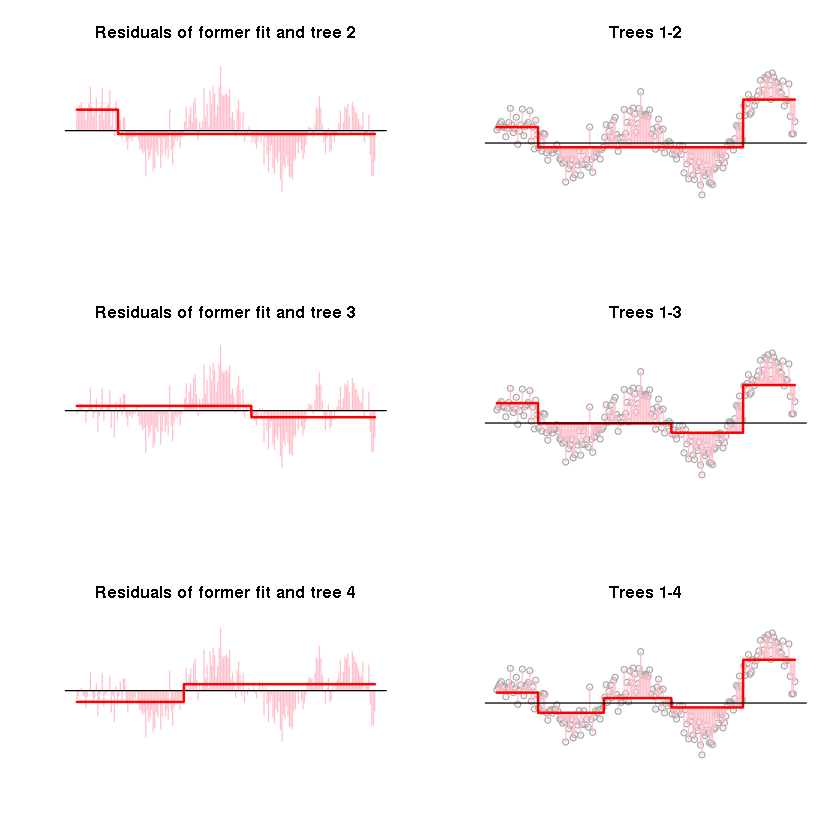

In [4]:
## Define number of trees to be fitted successifely to residuals:
n_stumps      <- 10

## Define number of trees to be fitted successifely to residuals:
plot_n_stumps <- 4

## This can be ignored (just defined such that cell works if executed repeatedly)
y_pred_all <- data.frame(predict(xy.stump.1, newdata=data.frame(X=x_pred_all)))
train.data.model["pred_stump_cumsum_1"] <- train.data.model$pred_stump_1

par(mfrow=c(plot_n_stumps-1,2))
for(n in 2:n_stumps) {
  ## Make prediction on residuals of last tree:
  formula    <- as.formula(paste0("resid_stump_",n-1," ~ X"))
  xy.stump.n <- rpart(formula,data=train.data.model,control=rpart.control(maxdepth=maxdepth_tree))
    
  ## Add residuals and predictions (at training datapoints) to dataframe:
  train.data.model[paste0("resid_stump_",n)] <- resid(xy.stump.n)
  train.data.model[paste0( "pred_stump_",n)] <- predict(xy.stump.n, newdata=data.frame(X=train.data.model$X))
  train.data.model[paste0( "pred_stump_cumsum_",n)] <- train.data.model[paste0("pred_stump_cumsum_",n-1)] +
                                                       train.data.model[paste0("pred_stump_",n)]
 
  ## Make prediction for complete x-axis (not just training datapoints):
  y_pred_all_n <- predict(xy.stump.n, newdata=data.frame(X=x_pred_all))
  y_pred_all   <- cbind(y_pred_all, y_pred_all[,(n-1)] + y_pred_all_n); names(y_pred_all) <- 1:n
    
  if(n <= plot_n_stumps) {
    ## Plot residuals of combined tree prediction (so far) and prediction with additional tree:
    plot(train.data.model$X, train.data.model[,paste0("resid_stump_",n-1)], type="h",
         ylim=range_resid_1, axes=F, xaxt='n', ann=FALSE, col="pink")
    abline(h=0)
    lines(x_pred_all, y_pred_all_n,col="red",lwd=2)
    title(main=paste0("Residuals of former fit and tree ",n))
    
    ## Plot training data and combined tree prediction and new residuals:
    #y_pred_all <- y_pred_all + y_pred_all_n
    plot(train.data.model$X, train.data.model$Y, ylim=c(-0.7,1),axes=F, xaxt='n', ann=FALSE, col="darkgrey")
    segments(x0=train.data.model$X, x1=train.data.model$X,
             y0=train.data.model[,paste0( "pred_stump_cumsum_",n)], y1=train.data.model$Y, col="pink")
    lines(x_pred_all,y_pred_all[,n],col="red",lwd=2)
    title(main=paste0("Trees 1-",n))
    abline(h=0)
  }
}

You see how the prediction gets more accurate for each added tree. We can also plot the change of the prediction with each added tree as an evolution, where the final prediction after iteratively fitting 10 trees on the residuals of the tree before is shown with the yellow line:

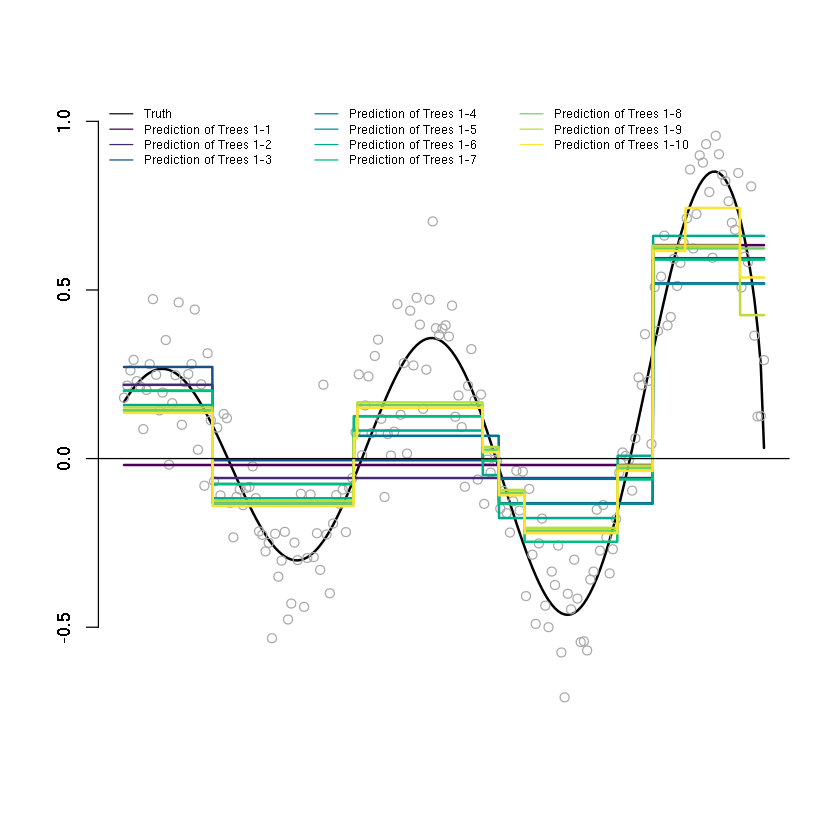

In [5]:
## Plot evolution of all successive tree changes:
line_colors <- hcl.colors(n_stumps, palette = "viridis")
plot(train.data$X, train.data$Y_true, lwd=2, axes=F, xaxt='n', ann=FALSE, ylim=c(-0.7,1), type="l")
points(train.data.model$X, train.data.model$Y,col="darkgrey")
matlines(x_pred_all, y_pred_all, col=line_colors,lty=1,lwd=2)
legend("topleft", legend=c("Truth", paste0("Prediction of Trees 1-",1:n_stumps)), lwd=1,
       col=c("black", line_colors), bty = "n", cex=0.6, ncol=3)
abline(h=0); axis(2)

This example also illustrates why trees are not quite ideal to fit continuous functions, and often are not ideal if problems are "too linear" (i.e., even with a lot of flexibility the tree can only predict something discountinous...).

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Are you happy with the boosting result?
- Can you explain, why the boosting has troubles fitting this data?
- Based on your explanation, what would be a strategy to improve to model?
- Set ```maxdepth_tree <- 2``` (top of third cell above) to see whether an improvement is possible.
</div>

## Boosting - Example of Boosted Trees on 2D artificial data

We generate the same non-linear 2D artificial dataset as for the last exercise and split it into 50% training and 50% testing data.

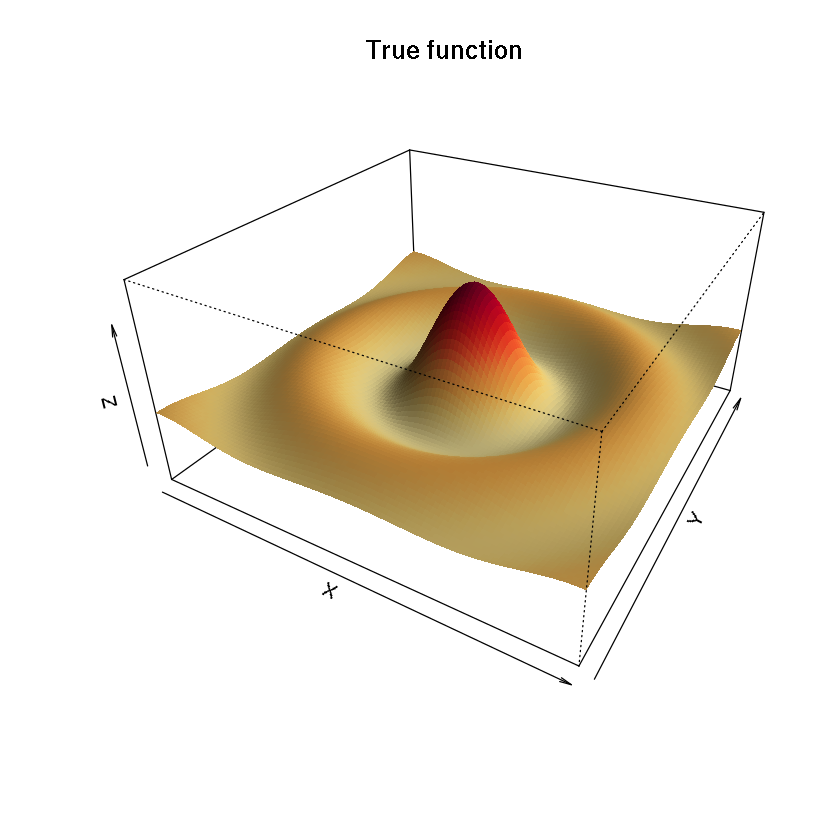

In [6]:
## Create explanatory variables
yy.lim <- xx.lim <- c(-10,10)
xx     <- seq(min(xx.lim),max(xx.lim),length.out=100)
yy     <- seq(min(yy.lim),max(yy.lim),length.out=100)
xy.mat <- expand.grid(x=xx,y=yy)

## Function for creating artificial response variable
zz.fun <- function(x,y){
    r <- sqrt(x^2+y^2)
    ro <- 10 * sin(r)/r
    return(ro)
}

## Compute z for all combinations x and y
data   <- data.frame(xy.mat,z=zz.fun(x=xy.mat$x,y=xy.mat$y))
N.data <- nrow(data)

## Add Gaussian noise (sd=0.5) to z-values:
set.seed(101)   
noise.sd <- 0.5
data$z.noisy <- data$z + rnorm(nrow(data),mean=0,sd=noise.sd)

## Let's use half of the data for training:
frac.test <- 0.5

## Select training and testdata:
test.ind   <- sample(N.data,round(frac.test*N.data))
test.data  <- data[test.ind,]
train.data <- data[-test.ind,]

## Sizes of training and test data
N.train.data <- nrow(train.data)
N.test.data  <- nrow(test.data)

## Plot true function:
par(mfrow=c(1,1))
plot.xyz.persp(x=data$x,y=data$y,z=data$z,axnames=T,title="True function")

We try the Boosted Tree method on this dataset, albeit with a low number of trees (5) and, as above, each tree is only allowed to split once.

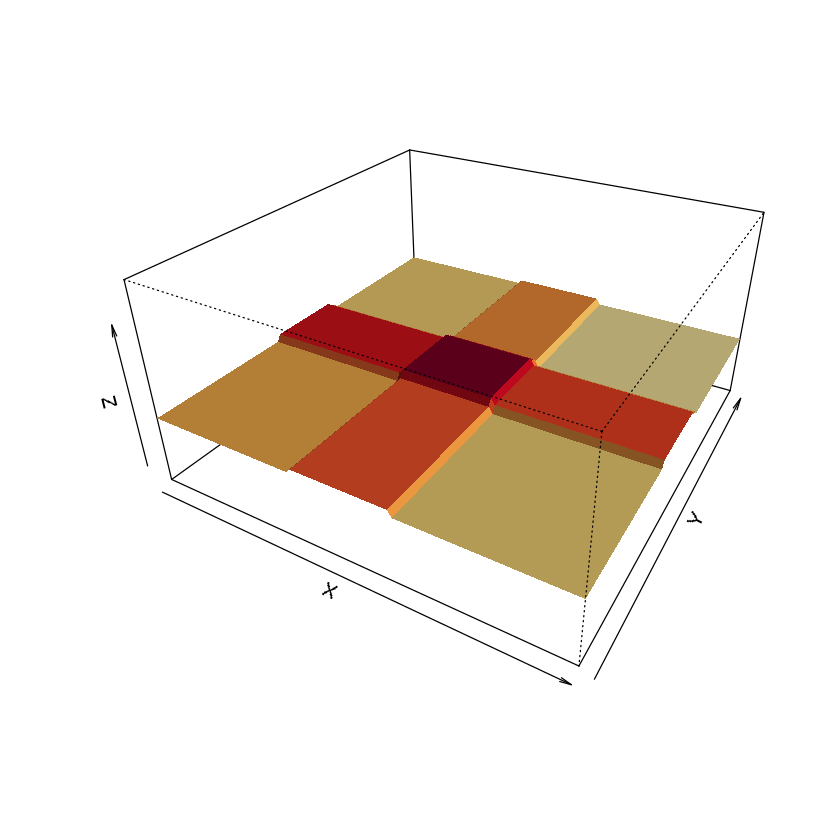

In [7]:
## Decide on function settings:
distribution_set  <- "gaussian" ## For squared error loss (for regression problem)
n_trees           <- 5          ## Number of trees
interaction_depth <- 1          ## Tree size (number of splits)
shrinkage_par     <- 1          ## "Regularisation"

## Fit boosted trees to droplet dataset:
gbm.fitted <- gbm(z.noisy~x+y, data=train.data,
                  distribution=distribution_set,
                  n.tree=n_trees,
                  interaction.depth=interaction_depth,
                  shrinkage=shrinkage_par,
                  bag.fraction=1)

## Plot prediction:
plot.xyz.persp(x=data$x,y=data$y,z=predict(gbm.fitted,newdata=data,n.tree=n_trees))

<div class="alert alert-block alert-info">
<b>Questions</b> 

- What could be an explanation for the cross-like shape of the prediction?
- Does increasing the number of trees help (e.g. setting ```n_trees <- 50```)?
- Leaving ```n_trees <- 50```, what is the effect of decreasing the regularisation ```shrinkage_par <- 0.1``` to a lower value (such that it actually has an influence)?
- Now try roughly optimal parameters by your own, what do you end up with?
</div>

## Cross-Validation on Boosted Trees

You have seen that Boosted Trees improve results, but the values we used for the number of trees `n_trees`and the number of allowed branches or splits per tree `interaction_depth` were probably too low to fit a model complex enough to follow the non-linear training data.

But, luckily, we know a procedure that helps us determine useful values for these hyperparameters - mighty Cross-Validation! Exemplarily, we try to find the optimal number of trees with the code below:

[1] "Optimal number of trees: 5"

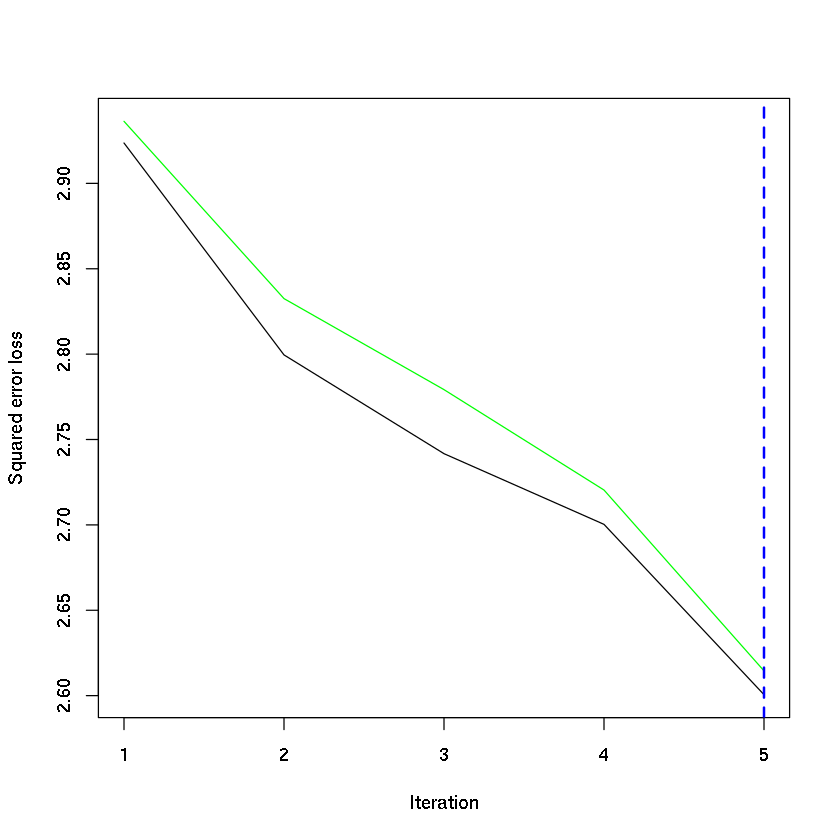

In [8]:
## Find optimal number of trees with the following function:
gbm.fitted <- gbm(z.noisy~x+y, data=train.data, distribution=distribution_set,
                  n.tree=n_trees, interaction.depth=interaction_depth,
                  shrinkage=shrinkage_par, bag.fraction=1, cv=5)
best.n.tree <- gbm.perf(gbm.fitted,method="cv")
sprintf("Optimal number of trees: %i", best.n.tree)

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Have a look at the help page of ```gbm.perf```-function and try to understand what it does.
- What do the curves in the plot show?
- Did you fit enough trees?
- Try to reproduce the training/validation-error plot on slide 14 (```shrinkage_par <- 1```)

</div> 

## Neural Networks - on 2D artificial data

Neural Networks consist of an **input layer**, a variable number of **hidden layers** and an **output layer**. Each of these layers consist of a number of **nodes**. The input layer takes the table of predictands and therefore has as many nodes as there are predictands. The output layer has as many nodes as there are predictors, usually one. The hidden layers can in principle have any number of hidden units. More than one hidden layer is usually refered to as Deep Learning. All of the units of each layer are connected with all units from the previous and the next layer. 

Once a datapoint is *fed* into the Neural Net for prediction, it is passed on through all the nodes until it arrives at the output node, which produces a value for the prediction. Each node, being confronted with a value, applies the globally defined **activation function** on the value, adds the individual **bias** term and passes it on through its weight connection th all the nodes in the next layer, albeit again exposed to another weight multiplication.

This architecture is mathematically quite convoluted to describe but quite intuitive to understand once visualised as a net of neurons, propagating information towards the output node:

<img src="figures/ann_arch.png" width=200 />

We fit a small ANN to the artificial 2D data. Neural Nets tend to have a lot of hyperparameters. We only use the two most important ones explained below:

- `maxit` is the maximum number of iterations the ANN will go through the training data to adjust its weights.
- `size` is the number of hidden units. Per default, the `nnet` package only allows singular hidden units. The number of units of the input layer is the number of variables from `train.data` (here, `x` and `y`) and the number of output units is the number of predictors (here, `z.noisy`). In principle, ANNs can have an unlimited amount of hidden layers (called deep learning) and several output layers. We limit ourselves to a small ANN for this tutorial.

The fitting procedure can be observed by the printout of the following piece of code: 

In [9]:
## Define maximum number of iterations for fitting the ANN
nn.maxit <- 500

## Fit network of size=5:
set.seed(456)
nn.fit.size5 <- nnet(z.noisy~x+y, data=train.data,
                     size=5,
                     maxit=nn.maxit,linout=TRUE)


# weights:  21
initial  value 15689.402374 
iter  10 value 13875.975785
iter  20 value 11953.625361
iter  30 value 11323.147613
iter  40 value 11163.951668
iter  50 value 11115.827827
iter  60 value 11078.794033
iter  70 value 11014.725796
iter  80 value 11013.409823
iter  80 value 11013.409772
iter  80 value 11013.409772
final  value 11013.409772 
converged


The ANN has converged, that means the fitting process is finished. We can inspect the weights of each node that have been learned (= adjusted) during the fitting procedure:

In [10]:
## Print fitted weigths:
sprintf("Number of weights: %i", length(nn.fit.size5$wts))
print(nn.fit.size5$wts)

[1] "Number of weights: 21"

 [1]  7.8030597  4.1692723 -1.0566490  6.1296847  2.2404030  2.3207705
 [7]  7.1317076 -1.7166490  3.6572140 -5.5888436  0.2004995  3.0413556
[13] -5.5949796  3.2081435  0.8074854 -1.2705198  1.6732249  1.6277130
[19]  1.8062527 -2.0888910 -1.9447208


<div class="alert alert-block alert-info">
<b>Questions</b> 

- Try to draw a figure of the network structure.

- From the output above, ...<br>... is there evidence that the model overfits the data?<br>... can you explain the number of fitted weights?

    
- It might helps to check out ```summary(nn.fit.size5)``` :)
</div> 

ANNs are best understood when looking at a visual sketch of it. Remember we have 2 inputs (`x`and `y`) and one output (`z`) and set `size` to 5, resulting in 21 weights. The following sketch shows the resulting ANN:

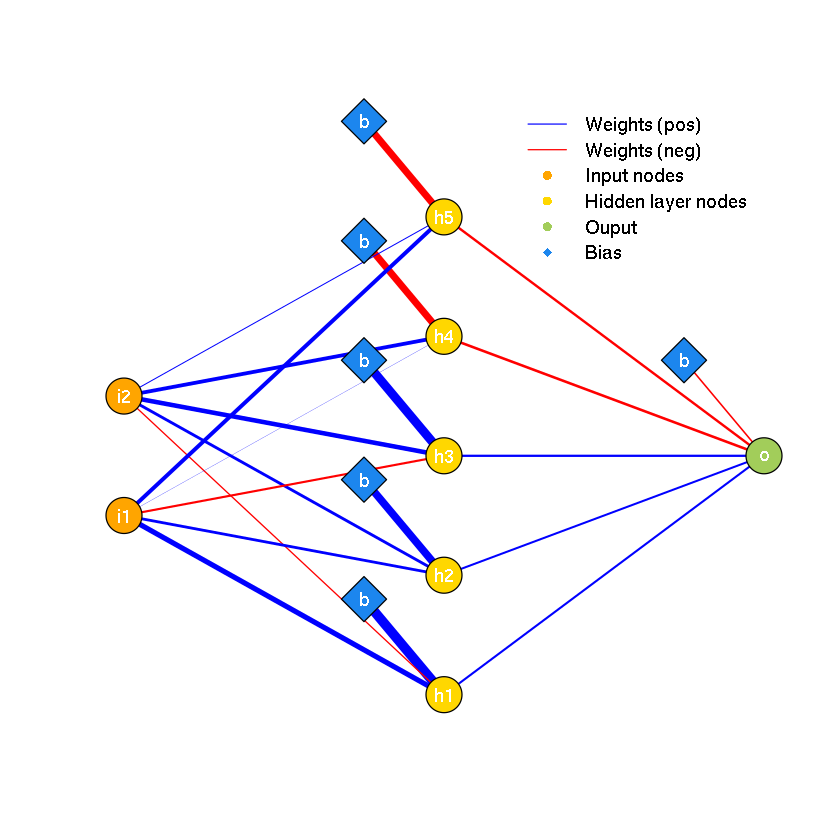

In [11]:
## Plot neural net:
plot_ann(n_input=2,n_hidden=5,weights=nn.fit.size5$wts)

Now that we have a fitted ANN, we can use it for predicting on the test dataset. For comparison, we also fit and predict with a large ANN (`size <- 50`) to see the impact of increasing the number of hidden units:

In [12]:
## Make prediction with small ANN on test-set (for MSE) and full dataset (for plotting):
nn.test.size5.pred <- predict(nn.fit.size5,newdata=test.data)
nn.pred.size.5 <- predict(nn.fit.size5,newdata=data)

## Fit a more complex model (hidden layer with 50 nodes):
nn.fit.size50 <- nnet(z.noisy~x+y,data=train.data,size=50,
                      maxit=nn.maxit,linout=TRUE, trace=F)

## Make prediction on test-set (for MSE) and full dataset (for plotting):
nn.test.size50.pred <- predict(nn.fit.size50,newdata=test.data)
nn.pred.size.50 <- predict(nn.fit.size50,newdata=data)

Compare the predictive power of both ANNs:

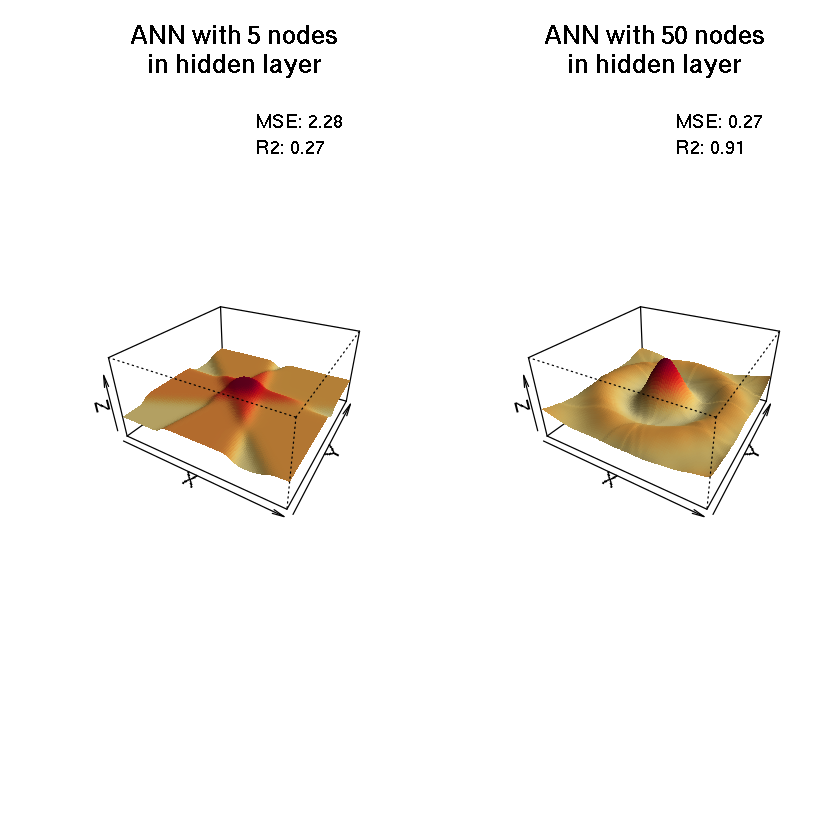

In [13]:
par(mfrow=c(1,2))
plot.xyz.persp(x=data$x,y=data$y,z=nn.pred.size.5)
legend("topright",legend=c(sprintf("MSE: %.2f",MSE(obs=test.data$z.noisy,pred=nn.test.size5.pred)),
                           sprintf("R2: %.2f",  R2(obs=test.data$z.noisy,pred=nn.test.size5.pred))),
       bty = "n")
title("ANN with 5 nodes\nin hidden layer")
plot.xyz.persp(x=data$x,y=data$y,z=nn.pred.size.50)
legend("topright",legend=c(sprintf("MSE: %.2f",MSE(obs=test.data$z.noisy,pred=nn.test.size50.pred)),
                           sprintf("R2: %.2f",  R2(obs=test.data$z.noisy,pred=nn.test.size50.pred))),
       bty = "n")
title("ANN with 50 nodes\nin hidden layer")

The effect of different hidden layer sizes (from 1 to 200) is shown in more detail also on slide 27 of the last lecture:

<img src="figures/ann_size.png" width=700 />

<div class="alert alert-block alert-info">
<b>Questions</b> 

- How could we counter potential over-fitting?
- Besides increasing the hidden layer size, what could be an option to increase the predictive power of the model?
</div> 

## Cross-Validation on ANNs

As you might have already heard short to a thousand times during this lecture, we use Cross-Validation to optimise hyperparameters of the model. This in principle also applies and works well for ANNs. However, since ANNs are very data-hungry and can training can easily become quite slow with a large amount of hidden units, Cross-Validation is usually quite expensive for ANNs. We will do it below for demonstration for the parameter `maxit`, but also note that the Lecture slides offer some alternative ways of avoiding overfitting while training an ANN:

In [14]:
## Define number of CV-folds and obtain CV-folds:
set.seed(123)
cv.K <- 6
cv.folds <- split(sample(1:N.train.data),
                  rep(1:cv.K, length = N.train.data))

## Define size of hidden layer:
net.size <- 50

## Define how many iterations should be tested:
sel.maxit <- seq(100,600,by=100)
print(paste(c("Number of iterations tested:",sel.maxit,"with",cv.K,"CV-folds each"),
            collapse=" "))

## Prepare empty matrix for saving MSE results
maxit.mse <- matrix(NA,ncol=cv.K,nrow=length(sel.maxit))
colnames(maxit.mse) <- paste("K",1:cv.K,sep=".")
rownames(maxit.mse) <- paste("maxit",sel.maxit,sep=".")

[1] "Number of iterations tested: 100 200 300 400 500 600 with 6 CV-folds each"


<div class="alert alert-block alert-danger">
ATTENTION: This cell will take a few minutes (~4min) to compute (time for ☕️😋)
</div>

In [15]:
## Loop over the different number of maximum iterations:
for(ii in seq_along(sel.maxit)) {
    mi <- sel.maxit[ii]
    cat(base::date(),"i =",ii," and maxit =",mi,"\n") ## print progress
    
    ## Now loop over the CV folds:
    for(kk in seq_along(cv.folds)){
        cat("\t",base::date(), "CV K =",kk,"...")
        sel.fold <- cv.folds[[kk]]
        
        ## Fit model on training folds:
        mi.fit <- nnet(z.noisy~x+y,
                       data=train.data[-sel.fold,], ## omit fold from training
                       size=net.size,maxit=mi,
                       abstol = 0, ## disable tolerance based early stopping
                       reltol = 0,
                       linout=TRUE,trace=FALSE)
        ## Predict on testing fold:
        mi.test.pred <- predict(mi.fit,newdata=test.data[sel.fold,]) ## predict on "sel.fold" only
        
        ## GET MSE on testing fold:
        maxit.mse[ii,kk] <- MSE(obs=test.data$z.noisy[sel.fold],pred=mi.test.pred)
        cat(" MSE =",maxit.mse[ii,kk],"\n")
    }
}

Tue Nov 17 21:54:14 2020 i = 1  and maxit = 100 
	 Tue Nov 17 21:54:14 2020 CV K = 1 ... MSE = 0.9060471 
	 Tue Nov 17 21:54:16 2020 CV K = 2 ... MSE = 1.014137 
	 Tue Nov 17 21:54:18 2020 CV K = 3 ... MSE = 0.8701274 
	 Tue Nov 17 21:54:21 2020 CV K = 4 ... MSE = 0.9119908 
	 Tue Nov 17 21:54:23 2020 CV K = 5 ... MSE = 0.7907135 
	 Tue Nov 17 21:54:25 2020 CV K = 6 ... MSE = 0.8699965 
Tue Nov 17 21:54:28 2020 i = 2  and maxit = 200 
	 Tue Nov 17 21:54:28 2020 CV K = 1 ... MSE = 0.6093838 
	 Tue Nov 17 21:54:32 2020 CV K = 2 ... MSE = 0.6428714 
	 Tue Nov 17 21:54:36 2020 CV K = 3 ... MSE = 0.4052146 
	 Tue Nov 17 21:54:41 2020 CV K = 4 ... MSE = 0.6467419 
	 Tue Nov 17 21:54:45 2020 CV K = 5 ... MSE = 0.4232352 
	 Tue Nov 17 21:54:49 2020 CV K = 6 ... MSE = 0.5995488 
Tue Nov 17 21:54:53 2020 i = 3  and maxit = 300 
	 Tue Nov 17 21:54:53 2020 CV K = 1 ... MSE = 0.3401801 
	 Tue Nov 17 21:54:59 2020 CV K = 2 ... MSE = 0.2987651 
	 Tue Nov 17 21:55:05 2020 CV K = 3 ... MSE = 0.2877548 

After we've had ample time for coffee, we can find the value for `maxit` with the lowest MSE:

In [17]:
## Get mean MSE for different maximum iterations:
mean.err <- rowMeans(maxit.mse)

## Get standard deviation of MSE for different maximum iterations:
sd.err <- apply(maxit.mse,1,sd)

## Find smallest mean MSE
sprintf("Lowest mean MSE: %.2f", (min.err <- min(mean.err)))

## number of iterations with the smallest error
sprintf("Iteration maximum with lowest mean MSE: %i", (opt_maxit <- sel.maxit[mean.err==min.err]))

[1] "Lowest mean MSE: 0.28"

[1] "Iteration maximum with lowest mean MSE: 500"

... and plot the results of the Cross-Validation:

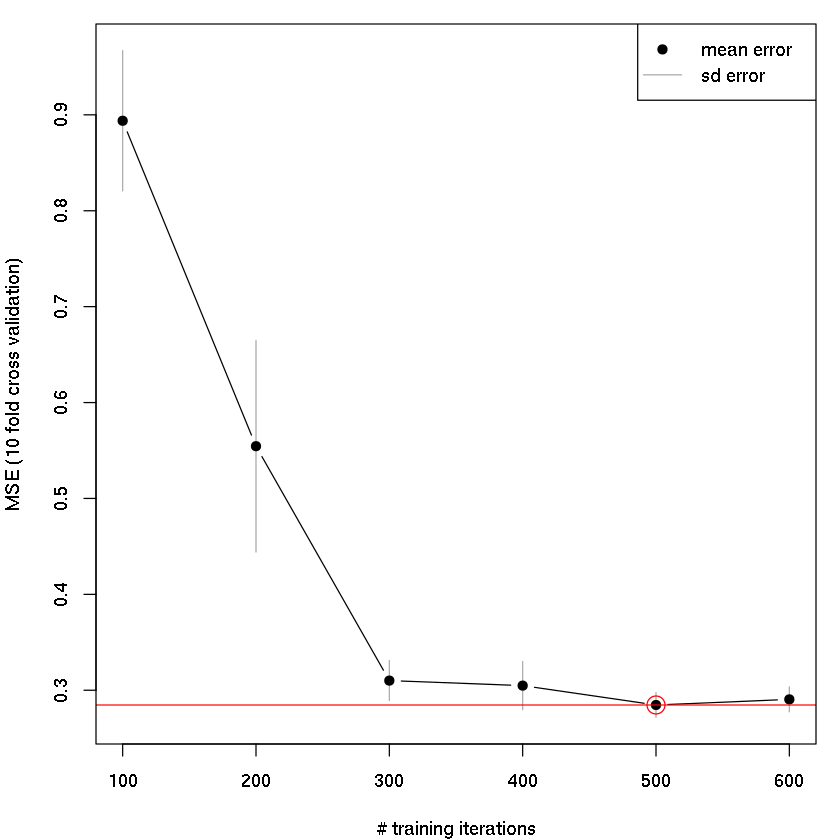

In [18]:
## Plot CV results
par(mar=c(4,4,1,1))
yy.lim <- range(c(mean.err+sd.err,mean.err-sd.err))
plot.new()
plot.window(xlim=range(sel.maxit),ylim=yy.lim)
segments(x0=sel.maxit,y0=mean.err+sd.err,y1=mean.err-sd.err,
         col="darkgray")
points(sel.maxit,mean.err,pch=19,t="b",col="black")
abline(h=min.err, col="red"); points(opt_maxit, min.err, cex=2, col="red")
axis(1);axis(2);box()
title(xlab="# training iterations",ylab="MSE (10 fold cross validation)")
legend("topright",legend=c("mean error","sd error"),
       pch=c(19,NA),lty=c(NA,1),col=c("black","darkgray"))

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Would you say that `500` might be the optimal value for `maxit` in this setting? Can you think of arguments against it?
- What are other methods for to control overfitting?
</div> 

## Boosted trees and ANN on PSL/precipitation dataset

You probably remember well our PSL/precipitation dataset. As a last part in this tutorial, we will fit both a Boosted Trees algorithm and an ANN to the data and compare their predictive power. Remember the structure of the dataset:

| | y | X_1 | X_2 | ... | X_p |
| :- | :- | :- | :- | :- | :- |
| | Precip_Zurich | PSL_lon$_1$lat$_1$ | PSL_lon$_2$lat$_1$ | .... | PSL_lon$_x$lat$_y$ |
| December year$_1$ | 0.242 | 156 | 81.5 | ... | ... | 
| January year$_2$ | -1.115 | 63.5 | 78 | ... | ... | 
| February year$_2$ | 2.129 | 78 | 117 | ... | ... | 
| December year$_2$ | -1.574 | 128.81 | -207.7 | ... | ... | 
| January year$_3$ | -1.333 | 170.6 | 53.3 | ... | ... | 
| ... |... | ... | ... | ... | ... | 
| December year$_n$ | ... | ... | ... | ... | ... | 
| January year$_n$ | ... | ... | ... | ... | ... | 
| February year$_n$ | ... | ... | ... | ... | ... | 

<img src="figures/Precip_PSL.png" width=300 height=450 />

We load the data and divide into training and validation parts:

In [23]:
## Load data from Exercise 2 Part 1:
load("../Exercise3/data/Exercise3_Part1_Data.RData")
str(Precip_PSL_df[,1:3])

## Rename predictor column names (otherwise the function call "Precip_Zurich ~ ." would not work):
Precip_PSL_df_new <- Precip_PSL_df
names(Precip_PSL_df_new)[2:ncol(Precip_PSL_df_new)] <- paste0("PSL",1:(ncol(Precip_PSL_df_new)-1))

## Specify training and validation indices:
set.seed(1234)
ind_train     <- sample(1:nrow(Precip_PSL_df), 2700)
ind_test      <- which(!(1:nrow(Precip_PSL_df) %in% ind_train))

'data.frame':	3000 obs. of  3 variables:
 $ Precip_Zurich   : num  0.242 -1.115 2.129 -1.574 -1.333 ...
 $ PSL_-10.00_31.26: num  156 63.5 160 -175.7 91.2 ...
 $ PSL_-7.50_31.26 : num  81.5 78 117 -207.7 53.3 ...


First we fit the boosted trees ...

In [24]:
## Decide on function settings:
distribution_set  <- "gaussian" ## For squared error loss (for regression problem)
n_trees           <- 5          ## Number of trees
interaction_depth <- 1          ## Tree size (number of splits)
shrinkage_par     <- 1          ## "Regularisation"

## Fit boosted trees to PSL/precip dataset:
gbm.fit <- gbm(Precip_Zurich~., data=Precip_PSL_df_new[ind_train,],
                  distribution=distribution_set,
                  n.tree=n_trees,
                  interaction.depth=interaction_depth,
                  shrinkage=shrinkage_par,
                  bag.fraction=1)


## Make prediction with boosted tree model on test dataset:
gbm.test.prediction <- predict(gbm.fit, newdata=Precip_PSL_df_new[ind_test,])

Using 5 trees...




Now we fit a neural network...

In [25]:
## Set maximum number of iterations:
nn.maxit <- 1000

## Set size of hidden layer:
n_nodes_h <- 10

system.time(
nnet.fit <- nnet(Precip_Zurich~.,data=Precip_PSL_df_new[ind_train,],
                 size=n_nodes_h,
                 maxit=nn.maxit,
                 linout=TRUE, trace=F))

## Make prediction with neural net model on test dataset:
nnet.test.prediction <- predict(nnet.fit, newdata=Precip_PSL_df_new[ind_test,])

ERROR: Error in nnet.default(x, y, w, ...): too many (3591) weights


Timing stopped at: 0.062 0 0.062



<div class="alert alert-block alert-info">
<b>Questions</b> 

- What happened here?! 😳 
- What could we do to get rid of this error?
</div> 

We have to perform feature selection, i.e. only using the 10 closest PSL grid points as predictors:

In [26]:
## Get the indices of the 10 closest gridpoints to Zurich:
n_closests_coord <- 10
ZH_lon <- 8.5417
ZH_lat <- 47.4

## Read indices from names in data.frame and calculate distance:
coord_vec        <- do.call(rbind,strsplit(names(Precip_PSL_df[,2:ncol(Precip_PSL_df)]),"_"))[,2:3]
class(coord_vec) <- "numeric"
dist_coord_ZH    <- dist(rbind(c(ZH_lon,ZH_lat), coord_vec))
ind_closest      <- order(dist_coord_ZH[1:nrow(coord_vec)])[1:n_closests_coord]

## Get subset of training data with gridpoints closest to Zurich:
Precip_PSL_df_closeZH <- Precip_PSL_df[,c(1,ind_closest+1)]
names(Precip_PSL_df_closeZH)[2:ncol(Precip_PSL_df_closeZH)] <- paste0("PSL",1:(ncol(Precip_PSL_df_closeZH)-1))

Now lets fit this neural net to the predictor subset and decrease the hidden layer size slightely:

In [27]:
## Set maximum number of iterations:
nn.maxit <- 1000

## Set size of hidden layer:
n_nodes_h <- 5

## Fit model to subset of predictors:
nnet.fit <- nnet(Precip_Zurich~.,data=Precip_PSL_df_closeZH[ind_train,],
                 size=n_nodes_h,
                 maxit=nn.maxit,
                 linout=TRUE, trace=F)

## Make prediction with neural net model on test dataset:
nnet.test.prediction <- predict(nnet.fit, newdata=Precip_PSL_df_closeZH[ind_test,])

Plot network and weights:

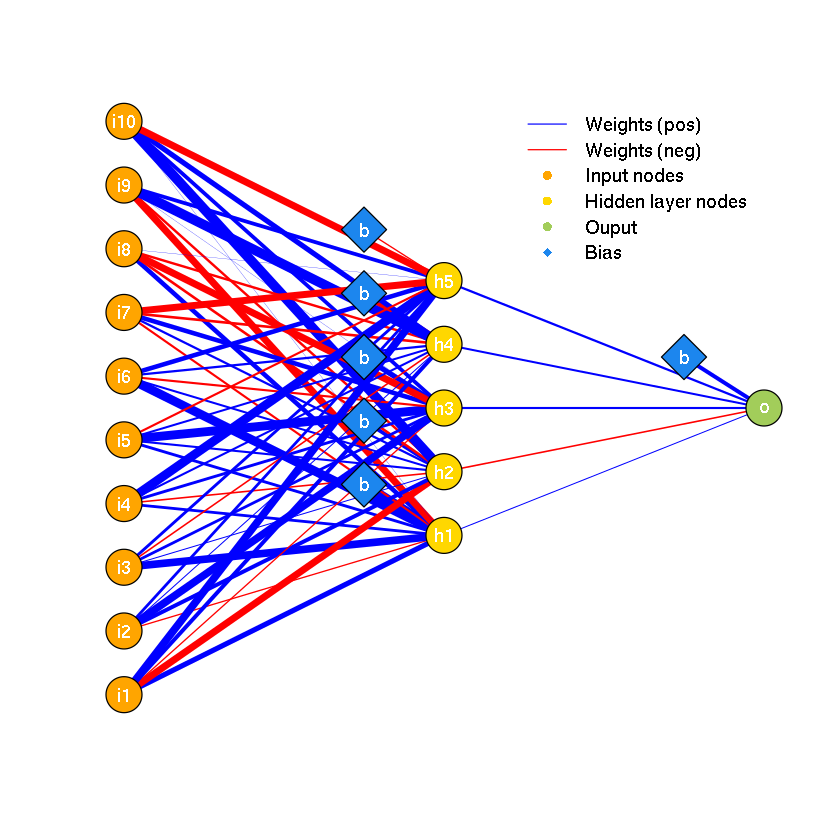

In [28]:
plot_ann(n_input=n_closests_coord,n_hidden=n_nodes_h,weights=nnet.fit$wts)

Finally, we can compare the performance of the Boosted Trees and the ANN on predicting precipitation in Zürich:

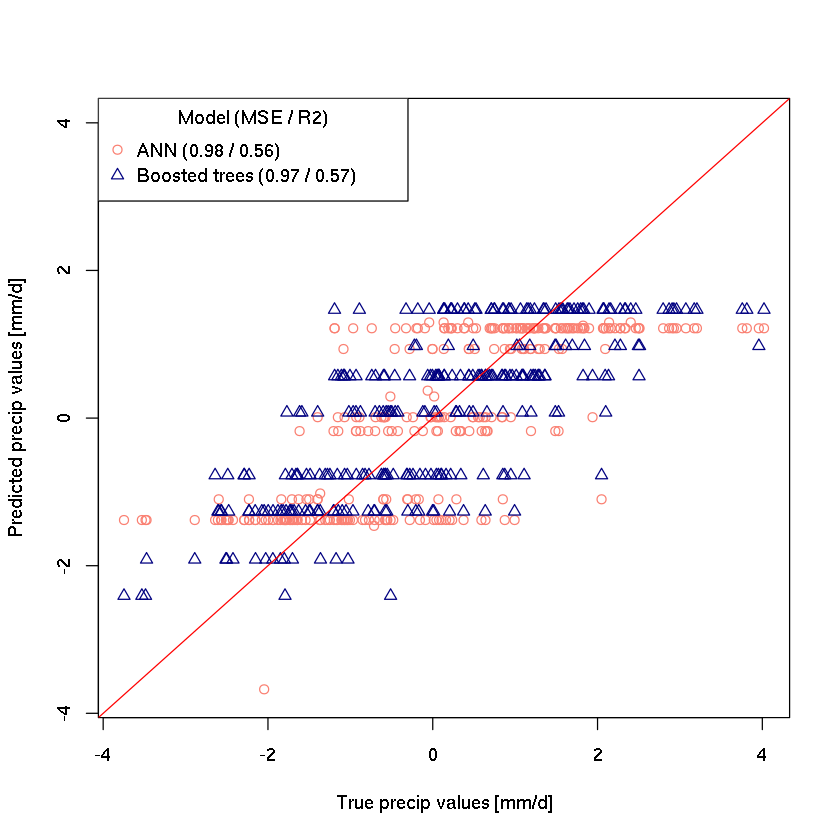

In [29]:
## Compare prediction with validation (test) data:
plot_range <- range(Precip_PSL_df$Precip_Zurich[ind_test],nnet.test.prediction)
plot(Precip_PSL_df$Precip_Zurich[ind_test],nnet.test.prediction,col="salmon",
     xlab="True precip values [mm/d]",ylab="Predicted precip values [mm/d]",
     xlim=plot_range,ylim=plot_range, pch=1)
points(Precip_PSL_df$Precip_Zurich[ind_test],gbm.test.prediction,col="navyblue", pch=2)
legend("topleft",
       legend=c(sprintf("ANN (%.2f / %.2f)",
                        MSE(Precip_PSL_df$Precip_Zurich[ind_test],nnet.test.prediction),
                        R2(Precip_PSL_df$Precip_Zurich[ind_test],nnet.test.prediction)),
                sprintf("Boosted trees (%.2f / %.2f)",
                        MSE(Precip_PSL_df$Precip_Zurich[ind_test],gbm.test.prediction),
                        R2(Precip_PSL_df$Precip_Zurich[ind_test],gbm.test.prediction))),
      pch=c(1,2,5),col=c("salmon","navyblue","darkgreen"), title="Model (MSE / R2)")
abline(0,1,col="red")

<div class="alert alert-block alert-info">
<b>Questions</b> 
    
- Explaining the banded predictions of the boosted tree is easy, but can you also explain the banded predictions of the ANN?
- Try to (manually) optimise the parameters of the boosted tree.
- Can you find an network architecture (number of predictor gridpoints, hidden layer size) which is able to beat the boosted tree prediction?
</div> 

## [Bonus] Manually predict ANN using Matrix Multiplication

To better understand how an ANN gets from input datapoints to the prediction, we can manually predict the outcome of the ANN. For that, we only need to know the network structure, the weights, and the activation function and perform a bit of Matrix Multiplication. We use the network structure, the weights and the activation function from the ANN above with 5 hidden units.

The activation function in ```nnet``` is written in ```C``` (according to https://stats.stackexchange.com/questions/78252/whats-the-activation-function-used-in-the-nodes-of-hidden-layer-from-nnet-libra), defined as:

```C
static double
sigmoid(double sum)
{
    if (sum < -15.0)
    return (0.0);
    else if (sum > 15.0)
    return (1.0);
    else
    return (1.0 / (1.0 + exp(-sum)));
}
```
so we implement it in ```R``` the following way:

In [ ]:
## Define sigmoid function manually:
sigmoid_activation <- function(sum) {
    if(sum< -15) return(0.0) 
    else if(sum> 15) return(1.0)
    else return(1./(1+exp(-sum)))
}
sigmoid_activation_vec <- Vectorize(sigmoid_activation)

## Plot activation function:
x_sigmoid <- seq(-16,16,0.01)
plot(x_sigmoid, sigmoid_activation_vec(x_sigmoid), type="l",xlab="x",
     ylab=bquote("sigmoid(x) ="~1/(1+e^-x)), col="deepskyblue3", lwd=2)

We randomly select a number of points `n_pred`from our x-y-domain (-10 to plus 10 in both directions) and save them in a small dataframe `input_df` with the format (rows, columns) = (datapoints, features), where features are the input variables (`x` and `y`).

In [ ]:
## For how many random points should a prediction be made:
n_pred <- 1

## Make automatic and manual prediction:
x_pred <- runif(n_pred,-10,10); y_pred <- runif(n_pred,-10,10)
sprintf("Make prediction for points")
(input_df <- data.frame(x=x_pred,y=y_pred))

We use our already trained ANN from above and predict the points in `input_df` to compare with our manual prediction at the end:

In [ ]:
## Make prediction using 'predict' function:
sprintf("Prediction: %.2f", predict(nn.fit.size5,newdata=input_df))

From the trained ANN, we extract the weights (coefficients) of all input, hidden and output nodes plus all bias coefficients:

In [ ]:
## Get fitted coefficients:
all_coef <- coef(nn.fit.size5)
weights_i_h <- all_coef[grep("i", names(all_coef))]
weights_h_o <- all_coef[grep("h.->o", names(all_coef))]
bias_h      <- all_coef[grep("b->h", names(all_coef))]
bias_o      <- all_coef[grep("b->o", names(all_coef))]

We save all lists extracted above as matrices and are ready to unpack our Matrix Multiplication skills from our math courses in the first semester again:

In [ ]:
## From weight matrices and bias vectors:
sprintf("Input matrix (1x2):")
(input_matrix <- as.matrix(input_df))

sprintf("Weight matrix (2x5) inputs -> hidden layer:")
(weight_matrix_i_h <- matrix(weights_i_h,ncol=5))

sprintf("Weight matrix (5x1) hidden layer -> output:")
(weight_matrix_h_o <- matrix(weights_h_o,nrow=5,byrow=T))

sprintf("Bias vector (1x5) hidden layer:")
(bias_matrix_h <- matrix(bias_h,ncol=5))

sprintf("Bias vector (1x1) output:")
(bias_matrix_o <- matrix(bias_o))

The process of arriving at a prediction, given the input $x_i$, weights $w_{ij}$ $w_{jk}$, network structure and activation function $\sigma$ is described on slide 25 of the previous lecture:

<img src="figures/forward_propagation.png" width=300 />

This formula can equivalently be expressed in matrix notation:

$y = \sigma(XW_{inner} + B_{hidden})W_{outer} + B_{output}$

where $X$ are the inputs, $W_{inner}$ are the weights $w_{ij}$ connecting input layer and hidden layer, $W_{outer}$ are the weights $w_{jk}$ connection hidden layer and output layer and $B$ are the bias vectors.

We calculate the resulting $y$ vector by applying matrix multiplication from left (input nodes) to right (output nodes):

In [ ]:
sprintf("Multiplication of input matrix and weights(i->h):")
(mat_iw <- input_matrix %*% weight_matrix_i_h)

sprintf("Adding the biases of the hidden layer nodes:")
(mat_iwb <- mat_iw + matrix(rep(bias_matrix_h,nrow(mat_iw)),
                            nrow=nrow(mat_iw),byrow=T))

sprintf("Apply sigmoid function (this is where the magic happens):")
(mat_siwb <- matrix(sigmoid_activation_vec(mat_iwb),nrow=nrow(mat_iwb)))

sprintf("Multiply weights(h->o):")
(mat_wsiwb <- mat_siwb %*% weight_matrix_h_o)

sprintf("Adding the bias of the output node to obtain the final prediction:")
(mat_wsiwbb <- mat_wsiwb + rep(bias_matrix_o,nrow(mat_wsiwb)))

<div class="alert alert-block alert-info">
<b>Questions</b> 

- Do the two predictions agree?
- Try to follow the prediction steps in the cell above, does it make sense to you?
- Increase the number of prediction points by setting ```n_pred```to a higher integer.

</div> 